In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from wordcloud import WordCloud

# Understanding the dataset

In [35]:
data = pd.read_csv("data/train.csv")
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


**In the 'label' column:**
- 1 is unreliable
- 0 is reliable

Now, let us check for any missing values and display basic statistics of the dataset

In [36]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None
                 id         label
count  20800.000000  20800.000000
mean   10399.500000      0.500625
std     6004.587135      0.500012
min        0.000000      0.000000
25%     5199.750000      0.000000
50%    10399.500000      1.000000
75%    15599.250000      1.000000
max    20799.000000      1.000000


The distribution of the 'label' column is shown below

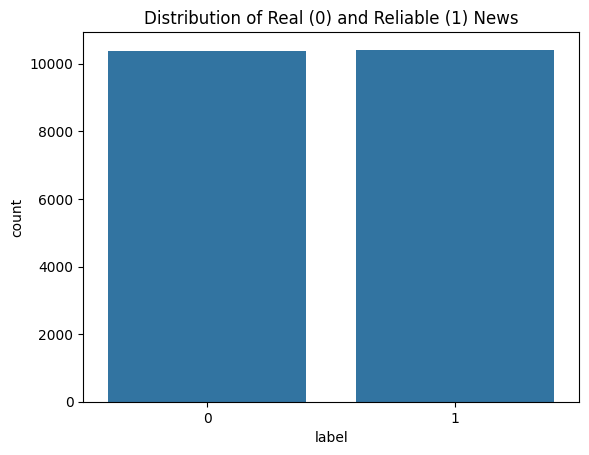

In [37]:
sns.countplot(x='label', data=data)

plt.title('Distribution of Real (0) and Reliable (1) News')
plt.show()

The count plot above shows that fake and real news is in equal distribution within the dataset.

# Cleaning the data 

The dataset contains some null values. Since only 39 of 20800 (0.19%) entries of the text column are not null, I will delete these samples. For now, I will disregard any other column entries which hold null values.

Let us visualise the percentage of null values of each column.

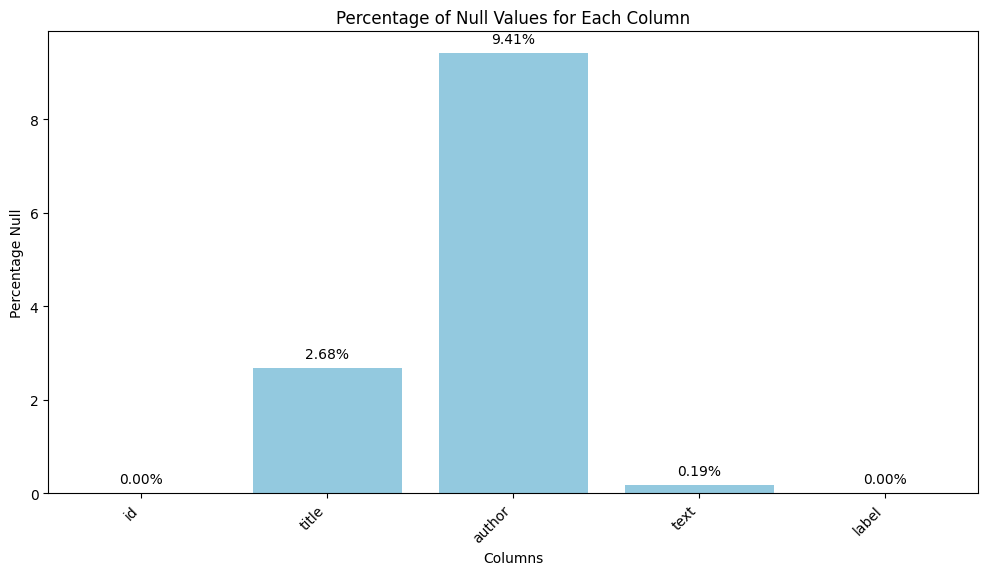

In [38]:
null_percentage = (data.isnull().sum() / len(data)) * 100

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=null_percentage.index, y=null_percentage.values, color='skyblue')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Null Values for Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Null')
plt.show()

In [42]:
data.dropna(subset=['text'], inplace=True)

print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 20761 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20761 non-null  int64 
 1   title   20203 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20761 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 973.2+ KB
None
                 id         label
count  20761.000000  20761.000000
mean   10401.130341      0.499687
std     6005.142716      0.500012
min        0.000000      0.000000
25%     5201.000000      0.000000
50%    10401.000000      0.000000
75%    15603.000000      1.000000
max    20799.000000      1.000000


Here, we have reduced the number of samples to 20761 (the number of non-null samples of the text column) from 20800.

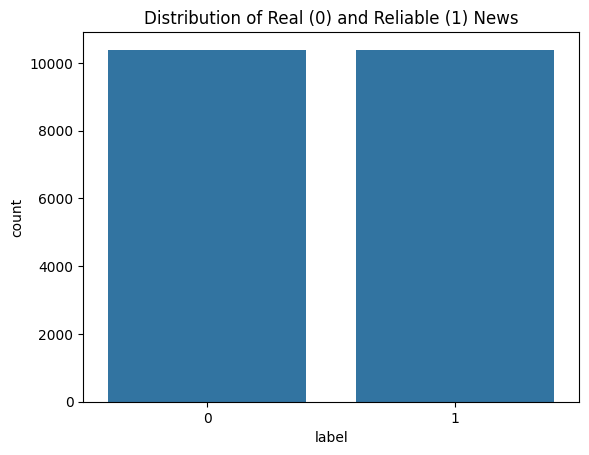

In [41]:
sns.countplot(x='label', data=data)

plt.title('Distribution of Real (0) and Reliable (1) News')
plt.show()

# Bag-of-words approach

Let us first start by tokenising and creating a bag-of-words representation of the text of each article.

The TF-IDF will transform the text into meaningful representation of integers or numbers; it measures the originality of a word by comparing the number of times a word appears in each article with the number of articles the word appears in.

In [46]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

X = tfidf_vectorizer.fit_transform(data['text'])

Now, I would like to add text length as a feature for each data sample.

In [47]:
data['text_length'] = data['text'].apply(len)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, data['label'], test_size=0.2, random_state=42
)

# Logistic Regression

In [49]:
logreg_model = LogisticRegression()

logreg_model.fit(X_train, y_train)

LogisticRegression()

Now, I will test the accuracy of the model.

In [56]:
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95


Since there was an equal distribution of 'reliable' and 'unreliable' news, this score is respectable - where a random guess strategy would yield, on average, a score of 50%.

### Classification Report

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2079
           1       0.94      0.96      0.95      2074

    accuracy                           0.95      4153
   macro avg       0.95      0.95      0.95      4153
weighted avg       0.95      0.95      0.95      4153



### Confusion Matrix

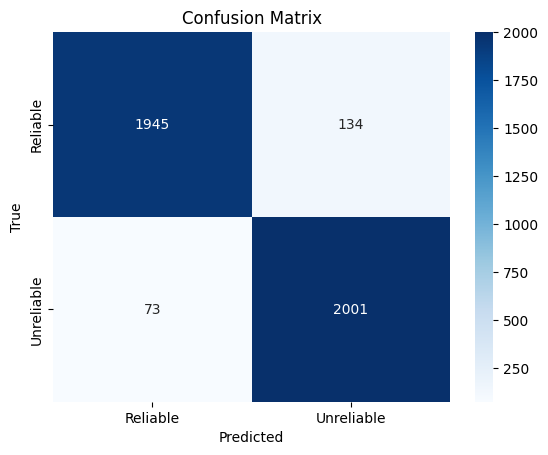

In [73]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

An interesting thing to observe when combining logistic regression with TF-IDF (bag of words) is the coefficient the model gives to each word. Below, I will visualise the coefficient (weight) of words in determining reliability of a given article.

### Top 10 words indicative of reliable news (according to model)

         Feature  Coefficient
1449        2016     7.354770
64238    hillary     6.270353
98355    october     5.928279
9905        anti     5.331873
97164   november     5.118631
28581    clinton     4.517870
124983     share     3.945955
96428        non     3.873785
44753      elect     3.760630
129387    source     3.623351


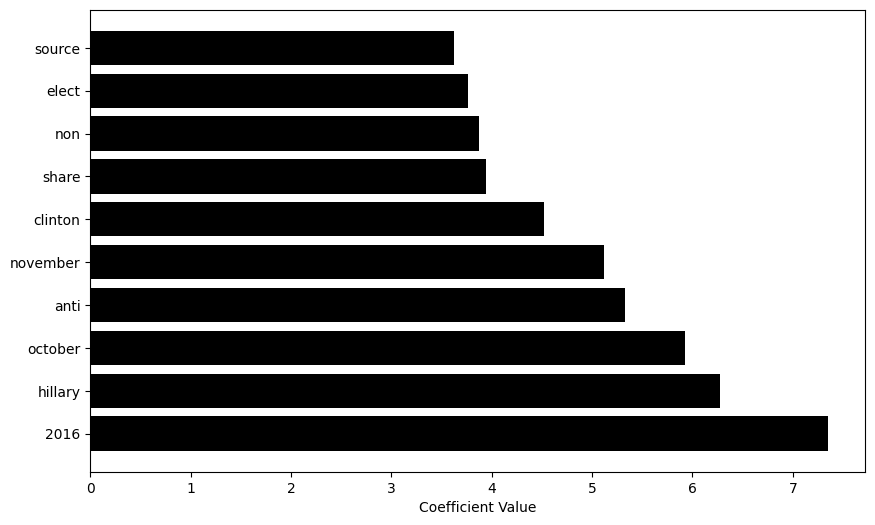

In [67]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = logreg_model.coef_.flatten()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
top_features = feature_importance.nlargest(10, 'Coefficient')

print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='black')
plt.xlabel('Coefficient Value')
plt.show()

### Word Cloud Representation

This word cloud shows the most common words within articles deemed 'reliable'.

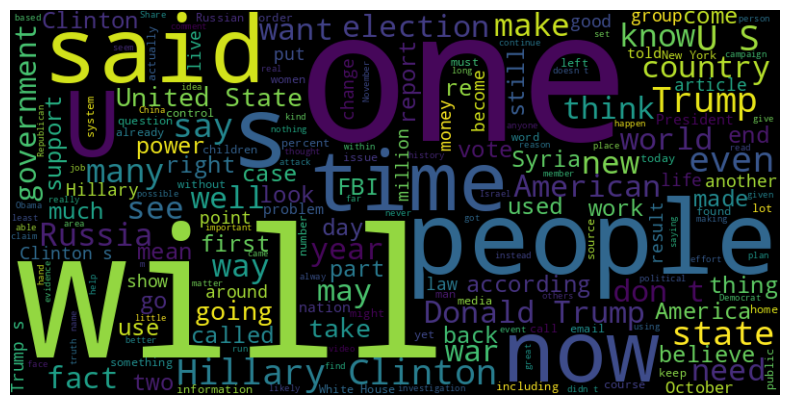

In [61]:
reliable_news_text = ' '.join(data[data['label'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(reliable_news_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Neural Network

In [76]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer

We need to choose values for the `vocab_size` and `max_length` variables. 

In [78]:
vocab_size = 10000
max_length = 200

In [79]:
max_word_length = 0
for text in X_train:
    words = text.split()
    max_word_length = max(max_word_length, max(len(word) for word in words))

print(f"Maximum Word Length: {max_word_length}")

# Step 2: Calculate Optimal Maximum Sequence Length
# Consider a percentile (e.g., 95th percentile) of word lengths
percentile_value = 95
optimal_max_length = int(np.percentile([len(word) for text in X_train for word in text.split()], percentile_value))

print(f"Optimal Maximum Sequence Length: {optimal_max_length}")

AttributeError: 'csr_matrix' object has no attribute 'split'